## **Import the necessary libraries**

In [4]:
pip install --upgrade cvlib

     |████████████████████████████████| 10.0 MB 3.7 MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.6-py3-none-any.whl size=10044619 sha256=4a3a57195c833dbe9a12d647b4c8a0577277b54dd6e553b1619c9ea37fc620de
  Stored in directory: /root/.cache/pip/wheels/9b/96/9b/373c07517ffe0bedbebc0813aec1e62cb2bb1dee91b3694895
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=d7619c1f649aef960c28184c6f28450595197a9380765c693ab572512ba83c01
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built cvlib progressbar


In [5]:
import cv2
import cvlib as cv
import os
import numpy as np
import pandas as pd
import skimage.io
import skimage.draw
import json
np.random.seed(1)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from keras.applications import vgg16
from keras.models import Model,load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation,Concatenate,Reshape
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(123)
import tensorflow as tf
from keras import backend as K
from keras.applications.mobilenet import MobileNet, preprocess_input
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
print(tf.__version__)

2.7.0


# **Import the dataset.**



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment'

In [7]:
dataImages = np.load('Dataset- Images.npy',allow_pickle= True)

In [8]:
dataImages.shape

(409, 2)

In [9]:
dataImages[272][1]

[{'imageHeight': 350,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7907692307692308, 'y': 0.07428571428571429},
   {'x': 0.9892307692307692, 'y': 0.5771428571428572}]},
 {'imageHeight': 350,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3707692307692308, 'y': 0.07428571428571429},
   {'x': 0.5923076923076923, 'y': 0.5028571428571429}]},
 {'imageHeight': 350,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.15384615384615385, 'y': 0.15142857142857144},
   {'x': 0.2907692307692308, 'y': 0.36857142857142855}]},
 {'imageHeight': 350,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.013846153846153847, 'y': 0.09142857142857143},
   {'x': 0.1123076923076923, 'y': 0.3314285714285714}]}]

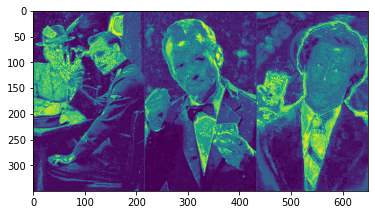

In [ ]:
image2 = dataImages[272][0].copy()
plt.imshow(image2)

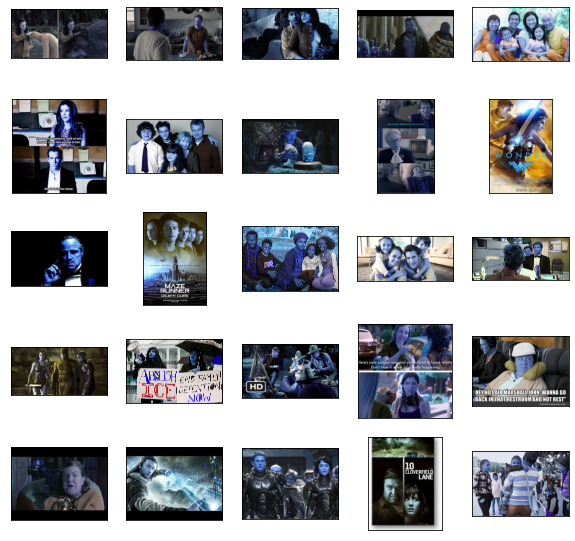

In [ ]:
# Listing from sample images from the Dataset- Images.npy
plt.figure(figsize=(10,10)) # plot 25 images
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(dataImages[i][0], cv2.COLOR_BGR2RGB))

# **Observations:**

- There are totally 409 images.
- Dataset- Images.npy contains the Image Height, IMage Width, StartX,StartY,EndX,EndY coordinates.

# **Create features (images) and labels (mask) using that data.**

# **We are creating mask with a box in the place of faces as one Dataset to know how the models are predicting.**

In [10]:
IMAGE_SIZE =224
targetMask = np.zeros((int(dataImages.shape[0]), IMAGE_SIZE, IMAGE_SIZE))
originalImages = np.zeros((int(dataImages.shape[0]), IMAGE_SIZE, IMAGE_SIZE,3))
for idx in range(dataImages.shape[0]):
  img = dataImages[idx][0]
  img = cv2.resize(img,dsize=(IMAGE_SIZE,IMAGE_SIZE),interpolation =cv2.INTER_CUBIC)
  try:
    img = img[:,:,:3]
  except:
    continue
  originalImages[idx] = preprocess_input(np.array(img,dtype=np.float32))
  for i in dataImages[idx][1]:
    x1 =int(i["points"][0]['x']*IMAGE_SIZE)
    x2 =int(i["points"][1]['x']*IMAGE_SIZE)
    y1 =int(i["points"][0]['y']*IMAGE_SIZE)
    y2 =int(i["points"][1]['y']*IMAGE_SIZE)
    targetMask[idx][y1:y2,x1:x2]=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


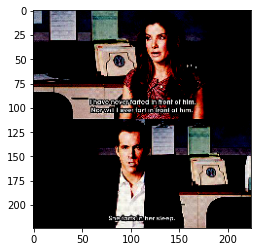

In [9]:
plt.imshow(originalImages[5])

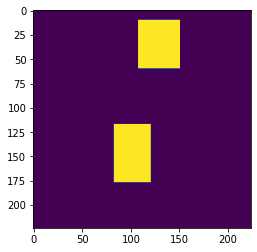

In [10]:
plt.imshow(targetMask[5])

In [11]:
#Creating Train and Test Split

X_train, X_test, y_train, y_test = train_test_split(originalImages, targetMask, test_size=0.2)

In [12]:
print('Shape of X_train - {} '.format(X_train.shape))
print('Shape of X_test - {} '.format(X_test.shape))
print('Shape of y_train - {} '.format(y_train.shape))
print('Shape of y_test - {} '.format(y_test.shape))

Shape of X_train - (327, 224, 224, 3) 
Shape of X_test - (82, 224, 224, 3) 
Shape of y_train - (327, 224, 224) 
Shape of y_test - (82, 224, 224) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


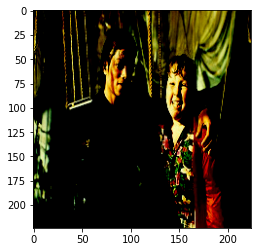

In [16]:
plt.imshow(X_train[10])

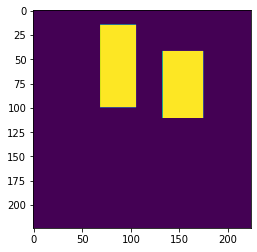

In [15]:
plt.imshow(y_train[10])

# **We are creating mask with a face as one Dataset to know how the models are predicting.**

In [13]:
movie_images = []
mask_images =[]
imageLength = len(dataImages)
for i in range(0,imageLength):
  extractImages = dataImages[i][0].copy()
  movie_images.append(dataImages[i][0].copy())
  json_string = json.dumps(dataImages[i][1])
  json_lst = json.loads(json_string)
  #print('Shape',extractImages.shape[0:2])
  mask = np.ones(shape=extractImages.shape[0:2], dtype="bool")
  #print(len(json_lst))
  for idx in json_lst:
    iter = 0
    X1 =0
    Y1 =0
    X2 =0
    Y2 =0
    imageHeight = idx.get('imageHeight')
    #print('imageHeight',imageHeight)
    imageWidth  = idx.get('imageWidth')
    #print('imageWidth',imageWidth)

    for pts in idx.get('points'):
      if(iter ==0):
        X1 = pts.get('x')
        Y1 = pts.get('y')
        iter = iter+1
        #print('X1',X1)
        #print('Y1',Y1)
        if(X1 ==1 or Y1 == 1):
           X1 =0.99
           Y1 =0.99
      else:
        X2 = pts.get('x')
        Y2 = pts.get('y')
        #print('X2',X2)
        #print('Y2',Y2)
        if(X2 ==1 or Y2 == 1):
           X2 =0.99
           Y2 =0.99
    rr, cc = skimage.draw.rectangle(start=(int(imageHeight* Y1),int(imageWidth*X1)), end=(int(imageHeight*Y2),int(imageWidth*X2)))
    mask[rr, cc] = False
    
  extractImages[mask] =0
  mask_images.append(extractImages)

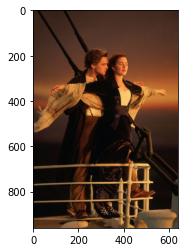

In [18]:
plt.imshow(movie_images[30])
plt.show()

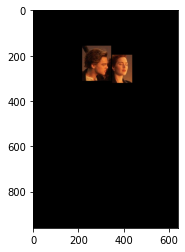

In [19]:
plt.imshow(mask_images[30])
plt.show()

In [14]:
IMAGE_SIZE =224

batch_images = np.zeros((len(movie_images), IMAGE_SIZE, IMAGE_SIZE,3))

for idx in range(0,len(movie_images)):
     img = movie_images[idx] 
     # Read image
     blueColor = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
     color = cv2.cvtColor(blueColor, cv2.COLOR_RGB2BGR)
     img = cv2.resize(color,(IMAGE_SIZE, IMAGE_SIZE))
     batch_images[idx] = preprocess_input(np.array(img, dtype=np.float32))

In [15]:
target_images = np.zeros((len(movie_images), IMAGE_SIZE, IMAGE_SIZE))

for idx in range(0,len(mask_images)):
     img = mask_images[idx] # Read image
     blueColor = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
     gray = cv2.cvtColor(blueColor, cv2.COLOR_RGB2GRAY) 
     img = cv2.resize(gray,(IMAGE_SIZE, IMAGE_SIZE))
     target_images[idx] = preprocess_input(np.array(img, dtype=np.float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


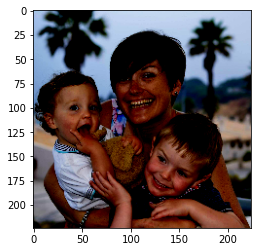

In [16]:
plt.imshow(batch_images[400])
plt.show()

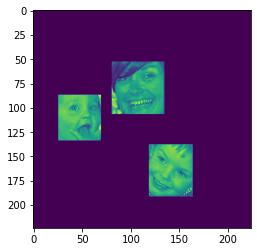

In [17]:
plt.imshow(target_images[400])
plt.show()

In [18]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(batch_images, target_images, test_size=0.3)

In [19]:
print('Shape of X_train - {} '.format(X_train1.shape))
print('Shape of X_test - {} '.format(X_test1.shape))
print('Shape of y_train - {} '.format(y_train1.shape))
print('Shape of y_test - {} '.format(y_test1.shape))

Shape of X_train - (286, 224, 224, 3) 
Shape of X_test - (123, 224, 224, 3) 
Shape of y_train - (286, 224, 224) 
Shape of y_test - (123, 224, 224) 


# **Observations:**

- Above we have created 2 types of Dataset for the Original images and face masks.
- X_train,X_test,y_train and y_test has the mask labels as rectangle Boxes.
- X_train1,X_test1,y_train1 and y_test1 has the mask labels as the face with low resolution.
- Even multiple faces are masked well.
- Both the original images and the masked images length are same.

# **Mask detection model:**

# **Design a face mask detection model using VGG16:**

In [ ]:
##Using VGG 16 Transfer learning Based UNet architecture
def ModelEnhancer():
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    VGG16 = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
    last_layer = VGG16.output
    
    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False
            
    model_ = Conv2DTranspose(512,(2,2),strides=(2, 2))(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)    
    
    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])

    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 

    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512,(2,2),strides=(2, 2))(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    model_= UpSampling2D()(model_)

    model_ = Conv2D(1, kernel_size=1, activation="sigmoid")(model_)
    model_ = Reshape((IMAGE_SIZE, IMAGE_SIZE))(model_)
    
    model_ = Model(VGG16.input,model_)
    
    return model_

In [ ]:
Model_VGG =ModelEnhancer()
Model_VGG.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                             

# **Design your own Dice Coefficient and Loss function.**

In [23]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [24]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

# **Train, tune and test the model:**

In [ ]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
Model_VGG.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint1 = ModelCheckpoint("/content/drive/MyDrive/CAPSTONE/Unet/checkpoint", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop1 = EarlyStopping(monitor='val_loss',patience = 10,restore_best_weights=True,mode = 'min')
reduce_lr1 = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

In [ ]:
#Here compling the model with Face Mask Labels as Boxes as prepared above
Model_VGG.fit(x=X_train,y=y_train, epochs=25,batch_size = 32,validation_split=0.35,callbacks=[stop1,checkpoint1])

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 2.0138 - dice_coefficient: 0.3063
Epoch 00001: val_loss improved from inf to 1.93291, saving model to /content/drive/MyDrive/CAPSTONE/Unet/checkpoint
7/7 [==============================] - 9s 1s/step - loss: 2.0138 - dice_coefficient: 0.3063 - val_loss: 1.9329 - val_dice_coefficient: 0.3060
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 1.4094 - dice_coefficient: 0.4409
Epoch 00002: val_loss did not improve from 1.93291
7/7 [==============================] - 4s 589ms/step - loss: 1.4094 - dice_coefficient: 0.4409 - val_loss: 2.0249 - val_dice_coefficient: 0.3114
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 1.0277 - dice_coefficient: 0.5534
Epoch 00003: val_loss did not improve from 1.93291
7/7 [==============================] - 4s 587ms/step - loss: 1.0277 - dice_coefficient: 0.5534 - val_loss: 2.1447 - val_dice_coefficient: 0.3170
Epoch 4/25
7/7 [==============================] - 

# **Evaluate the model using testing data:**

In [ ]:
Model_VGG.evaluate(X_test,y_test)

3/3 [==============================] - 1s 152ms/step - loss: 1.0992 - dice_coefficient: 0.4406


[1.099189043045044, 0.44058921933174133]

In [ ]:
testing_pred = Model_VGG.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Image


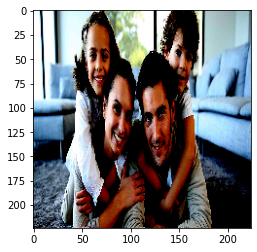

In [ ]:
print('Original Image')
plt.imshow(X_test[5])

Ground Truth


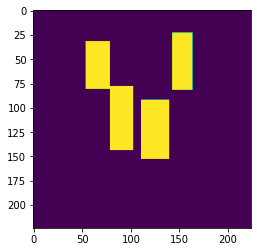

In [ ]:
print('Ground Truth')
plt.imshow(y_test[5])

Model Prediction


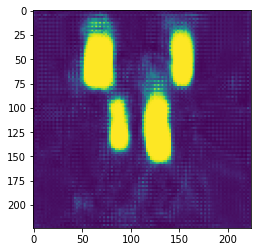

In [ ]:
print('Model Prediction')
plt.imshow(testing_pred[5])

# **Use the “Prediction image” as an input to your designed model and display the output of the image.**

(500, 500, 3)


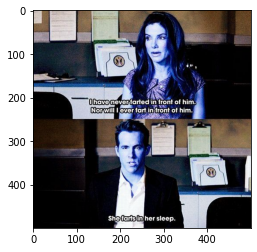

In [ ]:
image_1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/Test/Prediction_Image.jpeg')
plt.imshow(image_1)
print(image_1.shape)

In [ ]:
img_x1 = cv2.resize(image_1,dsize=(IMAGE_SIZE,IMAGE_SIZE),interpolation =cv2.INTER_CUBIC)

In [ ]:
img_x1 = img_x1.reshape(1,224,224,3)
prediction_1 = Model_VGG.predict(img_x1)

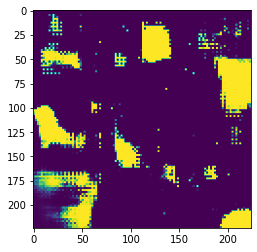

In [ ]:
pred_1 = prediction_1.reshape(224,224)
plt.imshow(pred_1)

# **Building the Unet using VGG16 and the Image Dateset with face as a mask Laebls**

In [ ]:
checkpoint2 = ModelCheckpoint("/content/drive/MyDrive/CAPSTONE/Unet/checkpoint", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop2 = EarlyStopping(monitor='val_loss',patience = 10,restore_best_weights=True,mode = 'min')
reduce_lr2 = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

In [ ]:
#Here compling the model with Face Mask Labels as face itself
Model_VGG.fit(x=X_train1,y=y_train1, epochs=25,batch_size = 32,validation_split=0.35,callbacks=[stop2,checkpoint2])

Epoch 1/25
6/6 [==============================] - ETA: 0s - loss: 0.2601 - dice_coefficient: 0.5341
Epoch 00001: val_loss did not improve from -1.57078
6/6 [==============================] - 4s 652ms/step - loss: 0.2601 - dice_coefficient: 0.5341 - val_loss: 1.3383 - val_dice_coefficient: 0.3875
Epoch 2/25
6/6 [==============================] - ETA: 0s - loss: -0.5037 - dice_coefficient: 1.8908
Epoch 00002: val_loss did not improve from -1.57078
6/6 [==============================] - 4s 617ms/step - loss: -0.5037 - dice_coefficient: 1.8908 - val_loss: 2.1498 - val_dice_coefficient: 0.4000
Epoch 3/25
6/6 [==============================] - ETA: 0s - loss: -0.6695 - dice_coefficient: 2.3662
Epoch 00003: val_loss did not improve from -1.57078
6/6 [==============================] - 4s 617ms/step - loss: -0.6695 - dice_coefficient: 2.3662 - val_loss: 1.6073 - val_dice_coefficient: 0.3053
Epoch 4/25
6/6 [==============================] - ETA: 0s - loss: -0.8670 - dice_coefficient: 1.9540
Epoc

In [ ]:
#Here compling the model with Face Mask Labels as face itself
Model_VGG.fit(x=X_train1,y=y_train1, epochs=3,batch_size = 32,validation_split=0.35,callbacks=[stop2,checkpoint2])

Epoch 1/3
6/6 [==============================] - ETA: 0s - loss: -4.7387 - dice_coefficient: 0.6643
Epoch 00001: val_loss improved from -1.57078 to -4.84605, saving model to /content/drive/MyDrive/CAPSTONE/Unet/checkpoint
6/6 [==============================] - 5s 895ms/step - loss: -4.7387 - dice_coefficient: 0.6643 - val_loss: -4.8461 - val_dice_coefficient: 0.1222
Epoch 2/3
6/6 [==============================] - ETA: 0s - loss: -4.8560 - dice_coefficient: 0.6436
Epoch 00002: val_loss improved from -4.84605 to -5.37221, saving model to /content/drive/MyDrive/CAPSTONE/Unet/checkpoint
6/6 [==============================] - 5s 851ms/step - loss: -4.8560 - dice_coefficient: 0.6436 - val_loss: -5.3722 - val_dice_coefficient: 0.0718
Epoch 3/3
6/6 [==============================] - ETA: 0s - loss: -4.9024 - dice_coefficient: 0.6098
Epoch 00003: val_loss improved from -5.37221 to -5.60634, saving model to /content/drive/MyDrive/CAPSTONE/Unet/checkpoint
6/6 [==============================] - 6

# **Evaluate the model using testing data.**

In [ ]:
Model_VGG.evaluate(X_test1,y_test1)

4/4 [==============================] - 4s 1s/step - loss: -5.3651 - dice_coefficient: 0.1315


[-5.3651442527771, 0.131472647190094]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Image


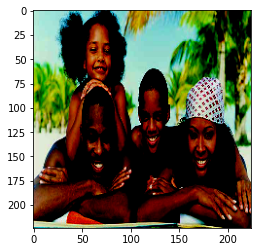

In [ ]:
print('Original Image')
plt.imshow(X_test1[5])

Original Image


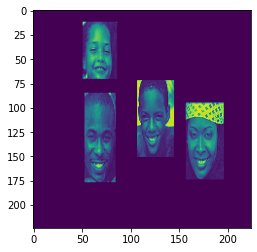

In [ ]:
print('Ground Truth')
plt.imshow(y_test1[5])

In [ ]:
testing_pred2 = Model_VGG.predict(X_test1)

Model Prediction


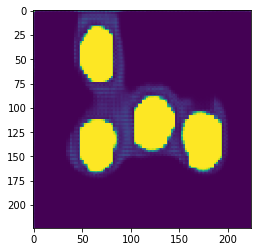

In [ ]:
print('Model Prediction')
plt.imshow(testing_pred2[5])

# **Use the “Prediction image” as an input to your designed model and display the output of the image:**

(500, 500, 3)


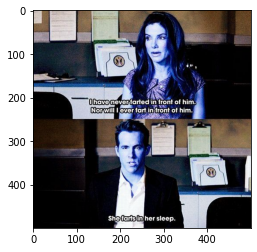

In [ ]:
image2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/Test/Prediction_Image.jpeg')
plt.imshow(image2)
print(image2.shape)

In [ ]:
img_x2 = cv2.resize(image2,dsize=(IMAGE_SIZE,IMAGE_SIZE),interpolation =cv2.INTER_CUBIC)

In [ ]:
img_x2 = img_x2.reshape(1,224,224,3)
prediction_2 = Model_VGG.predict(img_x2)

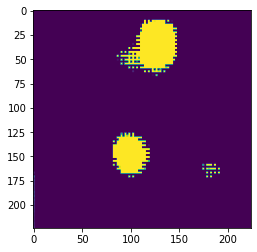

In [ ]:
pred_2 = prediction_2.reshape(224,224)
plt.imshow(pred_2)

# **Using MobileNet to create Unet Architecture:**

In [20]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    c1 = Concatenate()([UpSampling2D()(block4), block3])

    x = Conv2D(256,(3,3),strides=(1, 1),padding='same')(c1)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)


    c2 = Concatenate()([UpSampling2D()(x), block2])

    x = Conv2D(256,(3,3),strides=(1, 1),padding='same')(c2)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)


    c3 = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(256,(3,3),strides=(1, 1),padding='same')(c3)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)


    c4 = Concatenate()([UpSampling2D()(x), block0])

    x = Conv2D(256,(3,3),strides=(1, 1),padding='same')(c4)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)

    x= UpSampling2D()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)

    return Model(inputs=model.input, outputs=x)

In [21]:
model = create_model(False)
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                             

In [25]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
checkpoint3 = ModelCheckpoint("/content/drive/MyDrive/CAPSTONE/UnetMnet/checkpoint", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop3 = EarlyStopping(monitor='val_loss',patience = 10,restore_best_weights=True,mode = 'min')
reduce_lr3 = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

In [34]:
model.fit(x=X_train,y=y_train, epochs=30,batch_size = 32,validation_split=0.35,callbacks=[stop3,checkpoint3])

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 1.9016 - dice_coefficient: 0.3532
Epoch 00001: val_loss improved from inf to 2.99771, saving model to /content/drive/MyDrive/CAPSTONE/UnetMnet/checkpoint
7/7 [==============================] - 18s 1s/step - loss: 1.9016 - dice_coefficient: 0.3532 - val_loss: 2.9977 - val_dice_coefficient: 0.2656
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 1.4223 - dice_coefficient: 0.4530
Epoch 00002: val_loss improved from 2.99771 to 1.85015, saving model to /content/drive/MyDrive/CAPSTONE/UnetMnet/checkpoint
7/7 [==============================] - 3s 386ms/step - loss: 1.4223 - dice_coefficient: 0.4530 - val_loss: 1.8502 - val_dice_coefficient: 0.3619
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 1.0267 - dice_coefficient: 0.5556
Epoch 00003: val_loss improved from 1.85015 to 1.00581, saving model to /content/drive/MyDrive/CAPSTONE/UnetMnet/checkpoint
7/7 [==============================] - 3s 38

# **Evaluate the model using testing data:**

In [35]:
model.evaluate(X_test,y_test)

3/3 [==============================] - 1s 347ms/step - loss: 0.7512 - dice_coefficient: 0.6344


[0.7512283325195312, 0.6343745589256287]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original IMages:


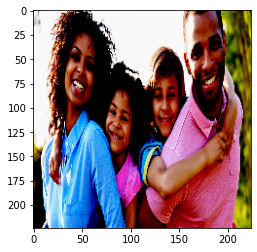

In [43]:
print("Original IMages:")
plt.imshow(X_test[75])

Original IMages:


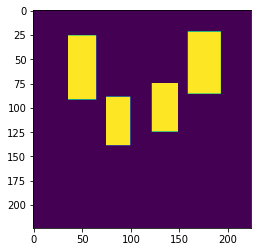

In [44]:
print("Original IMages:")
plt.imshow(y_test[75])

In [40]:
testing_pred_Mn2 = model.predict(X_test)

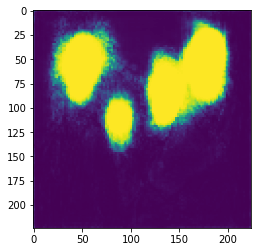

In [45]:
plt.imshow(testing_pred_Mn2[75])

# **Use the “Prediction image” as an input to your designed model and display the output of the image:**

(500, 500, 3)


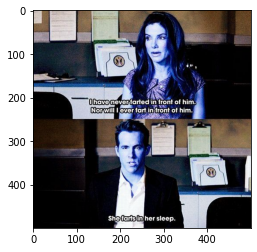

In [46]:
filename3 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/Test/Prediction_Image.jpeg')
plt.imshow(filename3)
print(filename3.shape)

In [47]:
img_x3 = cv2.resize(filename3,dsize=(IMAGE_SIZE,IMAGE_SIZE))

In [49]:
img_x3 = img_x3.reshape(1,224,224,3)

In [50]:
prediction3 = model.predict(img_x3)

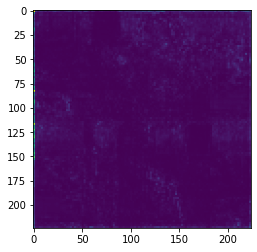

In [51]:
pred3 = prediction3.reshape(224,224)
plt.imshow(pred3)

# **Building the Unet using MobileNet and the Image Dateset with face as a mask Laebls:**

In [26]:
checkpoint4 = ModelCheckpoint("/content/drive/MyDrive/CAPSTONE/UnetMnet/checkpoint", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop4 = EarlyStopping(monitor='val_loss',patience = 10,restore_best_weights=True,mode = 'min')
reduce_lr4 = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

In [29]:
model.fit(x=X_train1,y=y_train1, epochs=5,batch_size = 32,validation_split=0.35,callbacks=[stop4,checkpoint4])

Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 0.0291 - dice_coefficient: 0.2760
Epoch 00001: val_loss improved from -1.40929 to -2.08865, saving model to /content/drive/MyDrive/CAPSTONE/UnetMnet/checkpoint
6/6 [==============================] - 2s 438ms/step - loss: 0.0291 - dice_coefficient: 0.2760 - val_loss: -2.0887 - val_dice_coefficient: 0.4860
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: -0.7477 - dice_coefficient: 0.6006
Epoch 00002: val_loss improved from -2.08865 to -2.47609, saving model to /content/drive/MyDrive/CAPSTONE/UnetMnet/checkpoint
6/6 [==============================] - 2s 410ms/step - loss: -0.7477 - dice_coefficient: 0.6006 - val_loss: -2.4761 - val_dice_coefficient: 0.6610
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: -1.3956 - dice_coefficient: 0.7042
Epoch 00003: val_loss improved from -2.47609 to -4.85490, saving model to /content/drive/MyDrive/CAPSTONE/UnetMnet/checkpoint
6/6 [=========================

# **Evaluate the model using testing data:**

In [30]:
model.evaluate(X_test1,y_test1)

4/4 [==============================] - 1s 335ms/step - loss: -7.2796 - dice_coefficient: 0.1476


[-7.279574871063232, 0.14758871495723724]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Images:


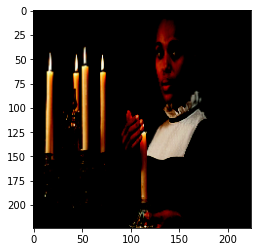

In [32]:
print("Original Images:")
plt.imshow(X_test1[55])

Ground Truth Images:


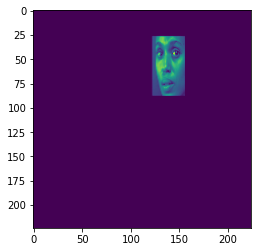

In [33]:
print("Ground Truth Images:")

plt.imshow(y_test1[55])

In [34]:
testing_pred_Mn4 = model.predict(X_test1)

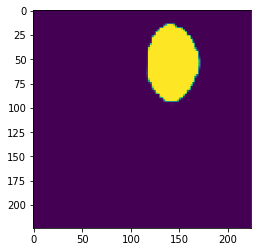

In [35]:
plt.imshow(testing_pred_Mn4[55])

# **Use the “Prediction image” as an input to your designed model and display the output of the image:**

(500, 500, 3)


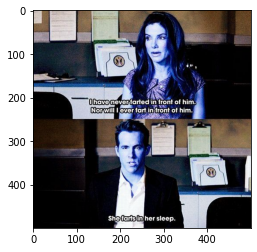

In [36]:
filename4 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/Test/Prediction_Image.jpeg')
plt.imshow(filename4)
print(filename4.shape)

In [37]:
img_x4 = cv2.resize(filename4,dsize=(IMAGE_SIZE,IMAGE_SIZE),interpolation =cv2.INTER_CUBIC)

In [38]:
img_x4 = img_x4.reshape(1,224,224,3)
prediction4 = model.predict(img_x4)

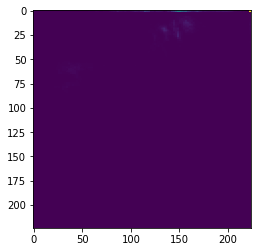

In [39]:
pred4 = prediction4.reshape(224,224)
plt.imshow(pred4)

# **Observations:**
- We have tried 2 different dataset with 2 different Transfer Learning Technique.
- VGG 16 with Rectangle Box as face Mask has the Dice Coefficient as 0.9049
- Predicts the Given image with less accuracy.
- VGG16 with less resolution face as Face mask has the Dice Coeffidient as 0.6098, predicts good.

- Mobile Net with Face Mask as rectangle Box has the Dice Coefficient has 0.8766, Predicts the given images with less accuracy.

- Mobile Net with Face Mask as face Mask  has the Dice Coefficient has 0.8912, Predicts the given images with less accuracy.

#PART TWO

# **Curate the bounding box co-ordinates for each image**




In [ ]:
def annotation():
  train_dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/training_images')
  print("----Started---------")
  print("<-- x -->,<-- y -->,<-- w -->,<-- h -->,Total_Faces,Image_Name")
  for image in train_dir:
    predictedFaces =0
    x =0
    y =0
    w =0
    h =0
    img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/training_images/'+image)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces, confidences = cv.detect_face(RGB_img)
    # loop through detected faces and add bounding box
    for face in faces:    
      (startX,startY) = face[0],face[1]
      (endX,endY) = face[2],face[3] 
      # draw rectangle over face
      if(startX < RGB_img.shape[1] and startY<RGB_img.shape[0] and endX<RGB_img.shape[1] and endY<RGB_img.shape[0]):
        predictedFaces=predictedFaces+1
        x = startX
        y = startY
        w = endX
        h = endY
      
    if(x ==0 and y ==0 and  w ==0 and h == 0):
      faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
      faces = faceCascade.detectMultiScale(RGB_img,scaleFactor=1.3,minNeighbors=3,minSize=(30, 30))

      for (x1, y1, w1, h1) in faces:
        predictedFaces=predictedFaces+1
        x =x1
        y =y1
        w =x1+w1
        h =y1+h1
    print(x,",",y,",",w,",",h,",",predictedFaces,",",image)
  print("----Finished---------")

In [ ]:
annotation()

----Started---------
<-- x -->,<-- y -->,<-- w -->,<-- h -->,Total_Faces,Image_Name
132 , 130 , 492 , 568 , 1 , real_00039.jpg
155 , 95 , 490 , 540 , 1 , real_00119.jpg
90 , 165 , 445 , 517 , 1 , real_00070.jpg
92 , 142 , 441 , 574 , 1 , real_00111.jpg
144 , 108 , 527 , 586 , 1 , real_00080.jpg
159 , 78 , 544 , 526 , 1 , real_00057.jpg
125 , 85 , 461 , 551 , 1 , real_00138.jpg
95 , 142 , 441 , 575 , 1 , real_00059.jpg
83 , 21 , 518 , 572 , 1 , real_00085.jpg
166 , 141 , 465 , 575 , 1 , real_00062.jpg
60 , 55 , 566 , 568 , 1 , real_00034.jpg
136 , 120 , 446 , 567 , 1 , real_00141.jpg
151 , 153 , 448 , 560 , 1 , real_00166.jpg
157 , 75 , 512 , 560 , 1 , real_00056.jpg
129 , 116 , 488 , 578 , 1 , real_00163.jpg
142 , 128 , 452 , 563 , 1 , real_00124.jpg
101 , 54 , 504 , 558 , 1 , real_00105.jpg
98 , 61 , 514 , 562 , 1 , real_00158.jpg
151 , 120 , 462 , 570 , 1 , real_00053.jpg
72 , 12 , 541 , 594 , 1 , real_00061.jpg
126 , 132 , 441 , 569 , 1 , real_00107.jpg
142 , 86 , 455 , 536 , 1 , re

# **Testing the Above samples**

***Generating Bounding Box using cvlib***

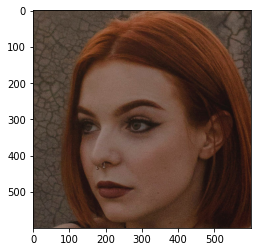

In [ ]:
im = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/training_images/real_00073.jpg')
RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()

In [ ]:
RGB_img.shape

(600, 600, 3)

131 , 143 , 450 , 578


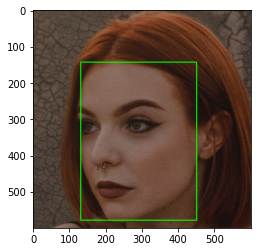

In [ ]:
faces, confidences = cv.detect_face(RGB_img)# loop through detected faces and add bounding box
for face in faces:    
    (startX,startY) = face[0],face[1]
    (endX,endY) = face[2],face[3] 
    
    # draw rectangle over face
    if(startX < RGB_img.shape[1] and startY<RGB_img.shape[0] and endX<RGB_img.shape[1] and endY<RGB_img.shape[0]):
      print(startX,",",startY,",",endX,",",endY)
      cv2.rectangle(RGB_img, (startX,startY), (endX,endY),(0,255,0), 2)
    
# display output        
plt.imshow(RGB_img)
plt.show()

# *Observation:*
  -  Automated annotation is proving the bounding Boxes and no. of faces detected in the images.
  - Above test sample Bounding Boxes matches with the automated annotation.
  - Bounding Coordinates (131 , 143 , 450 , 578) image Name: real_00073.jpg

# **Challenges:**

-  We have tried cvlib and haarcascades to detect the faces.
-  cvlib is not as good as haarcascades library, if the edges of the faces are not appeared properly then cvlib won't detect the face. Below is an example. But haarcascades predicts better in that case.

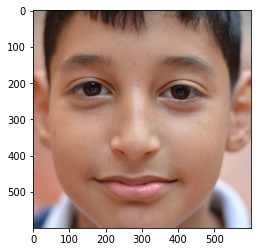

In [ ]:
im1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/training_images/real_00094.jpg')
RGB_img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img1)
plt.show()

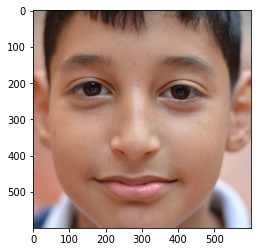

In [ ]:
faces, confidences = cv.detect_face(RGB_img1)# loop through detected faces and add bounding box
for face in faces:    
    (startX,startY) = face[0],face[1]
    (endX,endY) = face[2],face[3] 
    
    # draw rectangle over face
    if(startX < RGB_img1.shape[1] and startY<RGB_img1.shape[0] and endX<RGB_img1.shape[1] and endY<RGB_img1.shape[0]):
      print(startX,",",startY,",",endX,",",endY)
      cv2.rectangle(RGB_img1, (startX,startY), (endX,endY),(0,255,0), 2)
    
# display output        
plt.imshow(RGB_img1)
plt.show()

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    RGB_img1,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)

In [ ]:
print("[INFO] Found {0} Faces!".format(len(faces)))

[INFO] Found 1 Faces!


16 31 559 559


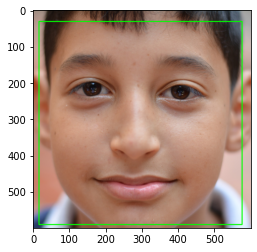

In [ ]:
for (x, y, w, h) in faces:
    print(x,y,w,h)
    cv2.rectangle(RGB_img1, (x, y), (x + w, y + h), (0, 255, 0), 2)

# display output        
plt.imshow(RGB_img1)
plt.show()

# **Challenges:**

- There are few images especially black peoples facimg are not getting detected properly. Below is one such sample.


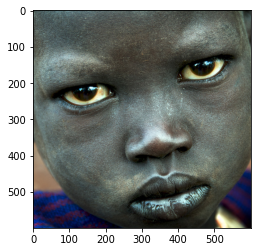

In [ ]:
im2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/training_images/real_00951.jpg')
RGB_img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img2)
plt.show()

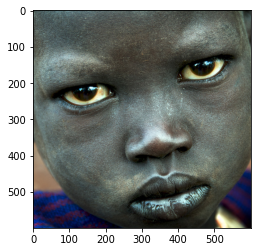

In [ ]:
faces, confidences = cv.detect_face(RGB_img2)# loop through detected faces and add bounding box
for face in faces:    
    (startX,startY) = face[0],face[1]
    (endX,endY) = face[2],face[3] 
    
    # draw rectangle over face
    if(startX < RGB_img1.shape[1] and startY<RGB_img1.shape[0] and endX<RGB_img1.shape[1] and endY<RGB_img1.shape[0]):
      print(startX,",",startY,",",endX,",",endY)
      cv2.rectangle(RGB_img2, (startX,startY), (endX,endY),(0,255,0), 2)
    
# display output        
plt.imshow(RGB_img2)
plt.show()

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    RGB_img2,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)

In [ ]:
print("[INFO] Found {0} Faces!".format(len(faces)))

[INFO] Found 0 Faces!


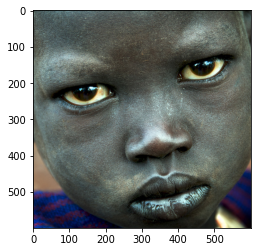

In [ ]:
for (x, y, w, h) in faces:
    print(x,y,w,h)
    cv2.rectangle(RGB_img2, (x, y), (x + w, y + h), (0, 255, 0), 2)

# display output        
plt.imshow(RGB_img2)
plt.show()

# **Challenges:**

- cvlib is not detecting the correct number of faces if the image has multiple faces whereas haarcascades detects well in that case

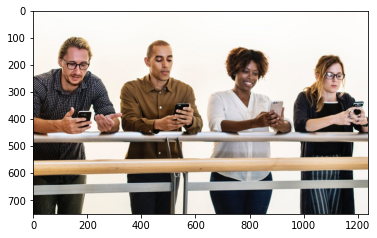

In [ ]:
im3 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Advanced CNN/Assignment/training_images/people_with_phones.jpg')
RGB_img3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img3)
plt.show()

437 , 122 , 521 , 258
108 , 140 , 209 , 275


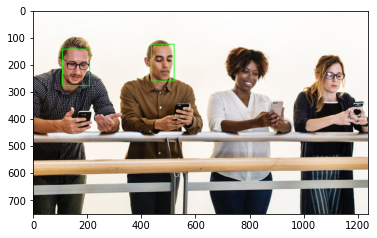

In [ ]:
faces, confidences = cv.detect_face(RGB_img3)# loop through detected faces and add bounding box
for face in faces:    
    (startX,startY) = face[0],face[1]
    (endX,endY) = face[2],face[3] 
    
    # draw rectangle over face
    if(startX < RGB_img1.shape[1] and startY<RGB_img1.shape[0] and endX<RGB_img1.shape[1] and endY<RGB_img1.shape[0]):
      print(startX,",",startY,",",endX,",",endY)
      cv2.rectangle(RGB_img3, (startX,startY), (endX,endY),(0,255,0), 2)
    
# display output        
plt.imshow(RGB_img3)
plt.show()

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    RGB_img3,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)

In [ ]:
print("[INFO] Found {0} Faces!".format(len(faces)))

[INFO] Found 4 Faces!


438 142 97 97
763 198 79 79
104 154 116 116
1018 183 151 151


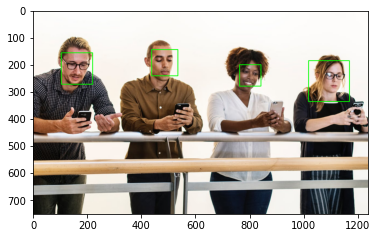

In [ ]:
for (x, y, w, h) in faces:
    print(x,y,w,h)
    cv2.rectangle(RGB_img3, (x, y), (x + w, y + h), (0, 255, 0), 2)

# display output        
plt.imshow(RGB_img3)
plt.show()